In [1]:
import os
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt



In [2]:
class ViraMinerDataset (Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def one_hot_encode(self, sequence):
        mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        seq_length = len(sequence)
        one_hot = th.zeros((seq_length, 4), dtype=th.float32)
        for i, base in enumerate(sequence):
            one_hot[i, mapping[base]] = 1

        return one_hot
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        one_hot_sequence = self.one_hot_encode(sequence)
        return one_hot_sequence, label

In [3]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), 'data'))
train_data_path = os.path.join(data_dir, 'fullset_train.csv')
val_data_path = os.path.join(data_dir, 'fullset_validation.csv')
test_data_path = os.path.join(data_dir, 'fullset_test.csv')

train_csv = pd.read_csv(train_data_path)
val_csv = pd.read_csv(val_data_path)
test_csv = pd.read_csv(test_data_path)

#drop the NaN values
train_csv = train_csv.dropna()
val_csv = val_csv.dropna()
test_csv = test_csv.dropna()

# get the sequences and labels
train_data = train_csv.values
val_data = val_csv.values
test_data = test_csv.values

m = train_data.shape[0]
train_sequences = train_data[:m, 1]
train_labels = train_data[:m, 2]

m = val_data.shape[0]
val_sequences = val_data[:m, 1]
val_labels = val_data[:m, 2]

m = test_data.shape[0]
test_sequences = test_data[:m, 1]
test_labels = test_data[:m, 2]

train_dataset = ViraMinerDataset(train_sequences, train_labels)
val_dataset = ViraMinerDataset(val_sequences, val_labels)
test_dataset = ViraMinerDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#free up some memory
del train_csv, val_csv, test_csv, train_data, val_data, test_data, train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_dataset, val_dataset, test_dataset

In [4]:
class LSTM_Net (nn.Module):
    def __init__ (self):
        super(LSTM_Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, batch_first=True, dropout=0.5)

        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)

        x = x[:, -1, :]
        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [5]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

# Model, loss function and optimizer
model = LSTM_Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 1
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (X_batch, Y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        # Forward pass
        outputs = model(X_batch.float())
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    train_losses.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with th.no_grad():
        for i, (X_val, Y_val) in enumerate(val_loader):
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)

            outputs = model(X_val.float())
            loss = criterion(outputs, Y_val)
            val_loss += loss.item()
        
    print(f"Validation Loss: {val_loss/len(val_loader)}")
    val_losses.append(val_loss/len(val_loader))
    

# Test the model
model.eval()
all_labels = []
all_preds = []
all_probs = []

with th.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = th.max(outputs, 1)
        
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())
        all_probs.extend(probs[:, 1].numpy())  # Probability of the positive class

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
auroc = roc_auc_score(all_labels, all_probs)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUROC: {auroc}")
        


Epoch 1, Loss: 0.10423069862064546
Validation Loss: 0.09992114968313756
Accuracy: 0.9791319497045902
Precision: 0.958699374932312
Recall: 0.9791319497045902
AUROC: 0.5331224570468676


c:\Users\pietr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


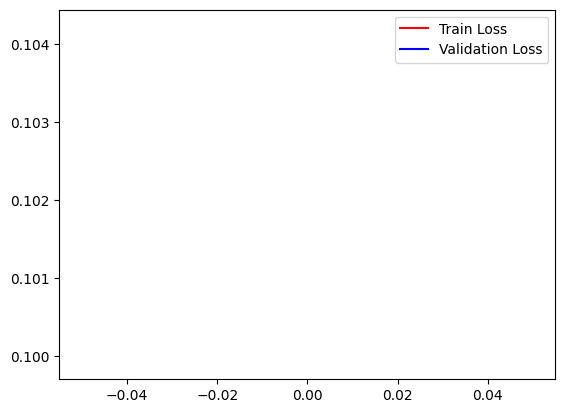

In [6]:

plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.legend()
plt.show()